<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, precision_recall_curve,
    classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
)

[10:25:37] WARNING: not removing hydrogen atom without neighbors


Value counts for 'Antioxidant':
Antioxidant
False    2077
True     1981
Name: count, dtype: int64 

Value counts for 'Anti-inflammatory':
Anti-inflammatory
False    2094
True     1964
Name: count, dtype: int64 

Value counts for 'Toxic':
Toxic
False    2084
True     1974
Name: count, dtype: int64 


=== Multiple Linear Regression for 'Antioxidant' ===

--- Cross-Validation Results ---
ROC AUC: 0.904 ± 0.004
Accuracy: 0.850 ± 0.006
F1 Score: 0.838 ± 0.007
R²: 0.536 ± 0.019
RMSE: 0.340 ± 0.007
MAE: 0.228 ± 0.004
AAD: 0.228 ± 0.004
Optimized threshold: 0.402

--- Final Hold-out Test Results ---
ROC AUC: 0.902
Accuracy (thresholded): 0.847
F1 Score (thresholded): 0.831
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       421
           1       0.89      0.78      0.83       391

    accuracy                           0.85       812
   macro avg       0.85      0.84      0.85       812
weighted avg       0.85      0

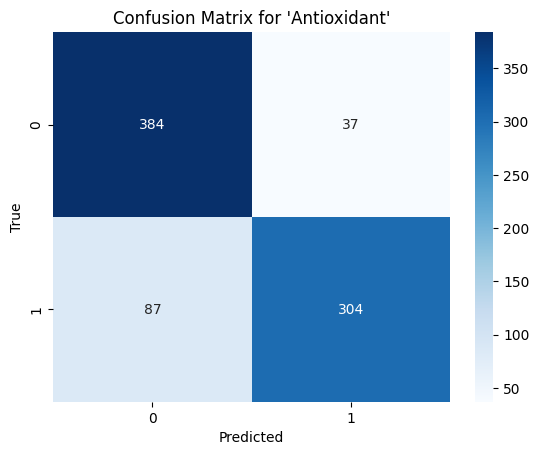

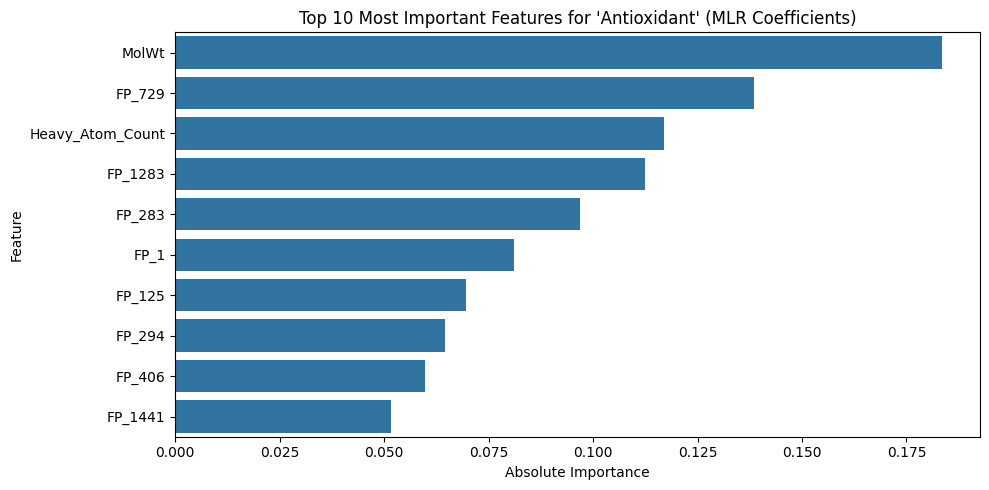

R² Score: 0.551
RMSE: 0.335
MAE: 0.237
AAD: 0.237


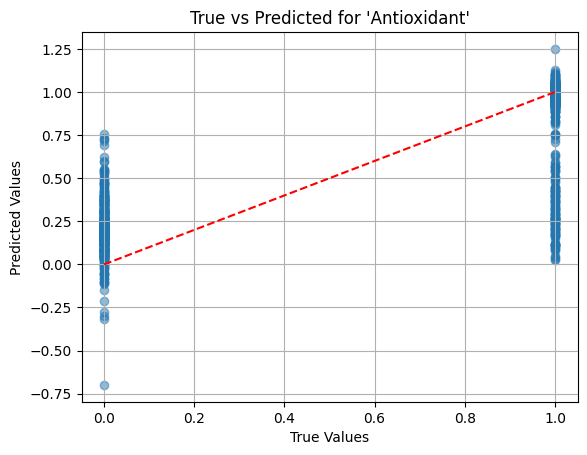


=== Multiple Linear Regression for 'Anti-inflammatory' ===

--- Cross-Validation Results ---
ROC AUC: 0.928 ± 0.008
Accuracy: 0.858 ± 0.011
F1 Score: 0.850 ± 0.012
R²: 0.572 ± 0.033
RMSE: 0.326 ± 0.013
MAE: 0.215 ± 0.009
AAD: 0.215 ± 0.009
Optimized threshold: 0.449

--- Final Hold-out Test Results ---
ROC AUC: 0.931
Accuracy (thresholded): 0.878
F1 Score (thresholded): 0.865
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       421
           1       0.92      0.81      0.87       391

    accuracy                           0.88       812
   macro avg       0.88      0.88      0.88       812
weighted avg       0.88      0.88      0.88       812



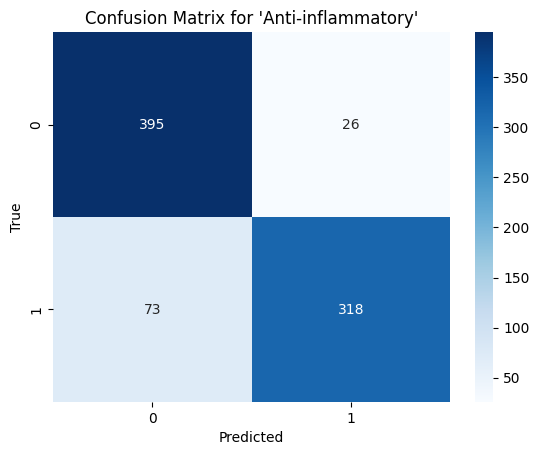

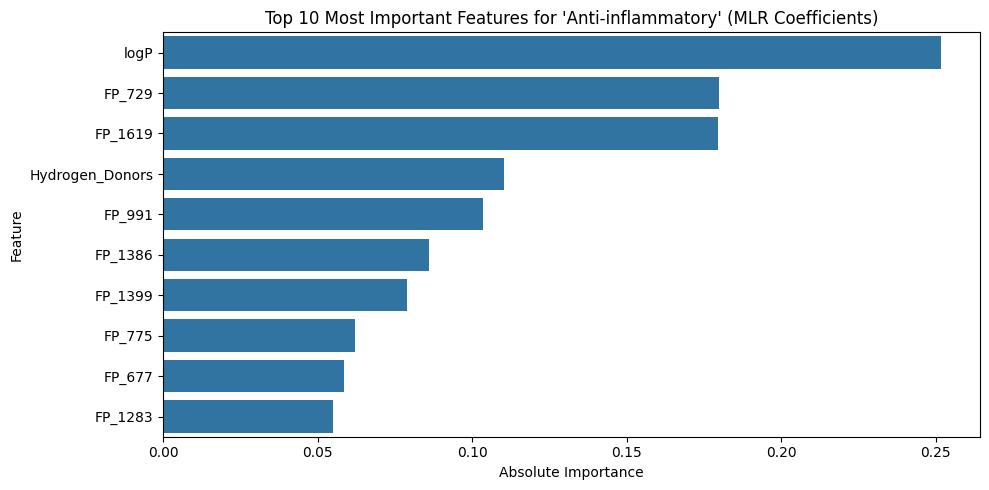

R² Score: 0.607
RMSE: 0.313
MAE: 0.216
AAD: 0.216


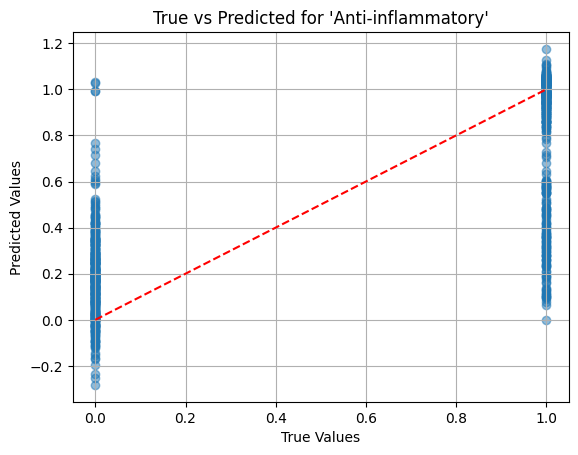


=== Multiple Linear Regression for 'Toxic' ===

--- Cross-Validation Results ---
ROC AUC: 0.925 ± 0.007
Accuracy: 0.845 ± 0.008
F1 Score: 0.857 ± 0.009
R²: 0.544 ± 0.043
RMSE: 0.337 ± 0.016
MAE: 0.226 ± 0.007
AAD: 0.226 ± 0.007
Optimized threshold: 0.561

--- Final Hold-out Test Results ---
ROC AUC: 0.925
Accuracy (thresholded): 0.866
F1 Score (thresholded): 0.869
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86       416
           1       0.83      0.91      0.87       396

    accuracy                           0.87       812
   macro avg       0.87      0.87      0.87       812
weighted avg       0.87      0.87      0.87       812



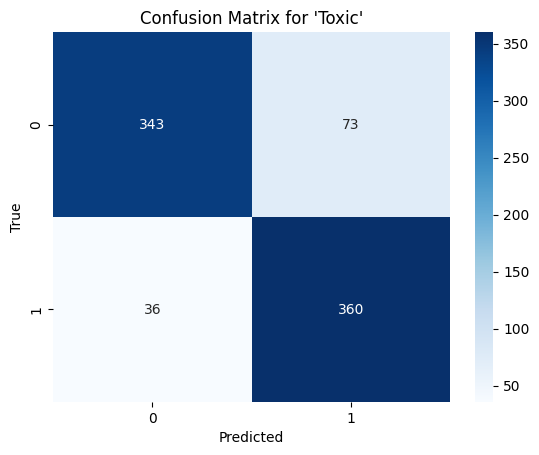

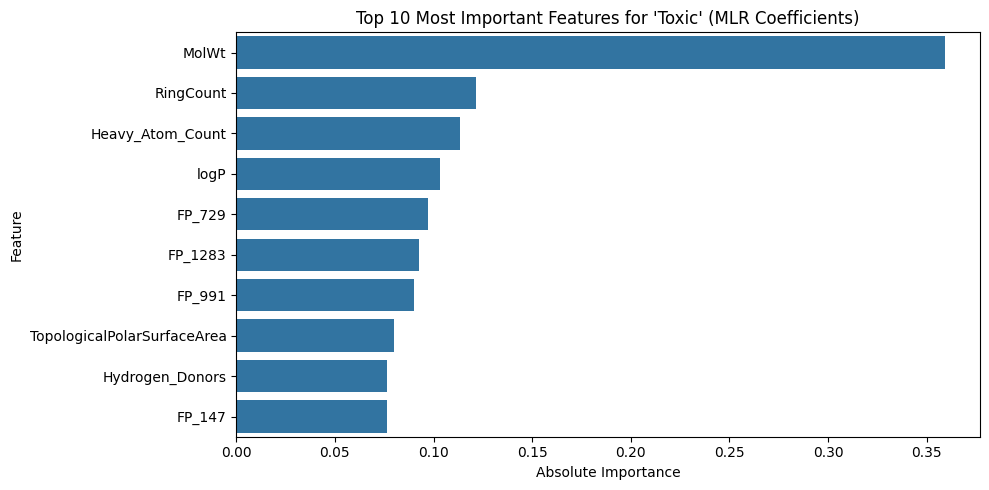

R² Score: 0.577
RMSE: 0.325
MAE: 0.229
AAD: 0.229


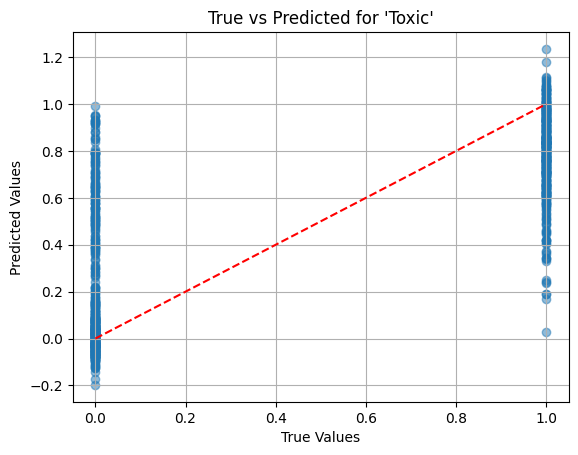

In [ ]:
# Load dataset
df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
smiles_list = df["SMILES"].tolist()

# Generate Morgan fingerprints
generator = GetMorganGenerator(radius=2, fpSize=2048)
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    else:
        fps.append(np.zeros((2048,), dtype=int))

fingerprint_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(2048)])

# Drop SMILES
df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])

# Define target columns
target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
for target in target_cols:
    print(f"Value counts for '{target}':")
    print(df[target].value_counts(), "\n")
df[target_cols] = df[target_cols].astype(int)

# Combine descriptors and fingerprints
descriptor_features = df.drop(columns=target_cols).select_dtypes(include='number')
features = pd.concat([descriptor_features, fingerprint_df], axis=1)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train and evaluate a separate MLR model for each target
for target in target_cols:
    print(f"\n=== Multiple Linear Regression for '{target}' ===")

    y = df[target].values
    X = features_scaled
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.2, random_state=42)

    # Repeated K-Fold CV on training data
    rkf = RepeatedKFold(n_splits=4, n_repeats=3, random_state=42)

    # Store fold-wise metrics
    acc_list, f1_list, auc_list = [], [], []
    r2_list, rmse_list, mae_list, aad_list = [], [], [], []

    fold = 1
    for train_idx, val_idx in rkf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Feature selection
        selector = SelectKBest(score_func=mutual_info_regression, k=100)
        X_tr_sel = selector.fit_transform(X_tr, y_tr)
        X_val_sel = selector.transform(X_val)

        # Model
        model = LinearRegression()
        model.fit(X_tr_sel, y_tr)
        y_val_pred = model.predict(X_val_sel)
        y_val_class = (y_val_pred >= 0.4).astype(int)

        # === Classification Metrics ===
        acc = accuracy_score(y_val, y_val_class)
        f1 = f1_score(y_val, y_val_class, zero_division=0)
        auc = roc_auc_score(y_val, y_val_pred)
        acc_list.append(acc)
        f1_list.append(f1)
        auc_list.append(auc)

        # === Regression Metrics ===
        r2 = r2_score(y_val, y_val_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        aad = np.mean(np.abs(y_val - y_val_pred))
        r2_list.append(r2)
        rmse_list.append(rmse)
        mae_list.append(mae)
        aad_list.append(aad)

        fold += 1

    # === Print Mean ± Std of all Metrics ===
    print("\n--- Cross-Validation Results ---")
    print(f"ROC AUC: {np.mean(auc_list):.3f} ± {np.std(auc_list):.3f}")
    print(f"Accuracy: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
    print(f"F1 Score: {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")
    print(f"R²: {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
    print(f"RMSE: {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
    print(f"MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
    print(f"AAD: {np.mean(aad_list):.3f} ± {np.std(aad_list):.3f}")

    # === Train on full training set and test on hold-out ===
    selector_final = SelectKBest(score_func=mutual_info_regression, k=min(100, X_train.shape[1]))
    X_train_sel = selector_final.fit_transform(X_train, y_train)
    X_test_sel = selector_final.transform(X_test)

    model_final = LinearRegression()
    model_final.fit(X_train_sel, y_train)
    y_test_pred = model_final.predict(X_test_sel)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)

    # Calculate F1 scores at each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimized threshold: {best_threshold:.3f}")

    # Apply best threshold
    y_test_class = (y_test_pred >= best_threshold).astype(int)


    print("\n--- Final Hold-out Test Results ---")
    acc_test = accuracy_score(y_test, y_test_class)
    f1_test = f1_score(y_test, y_test_class, zero_division=0)
    auc_test = roc_auc_score(y_test, y_test_pred)
    print(f"ROC AUC: {auc_test:.3f}")
    print(f"Accuracy (thresholded): {acc_test:.3f}")
    print(f"F1 Score (thresholded): {f1_test:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_test_class))

    cm = confusion_matrix(y_test, y_test_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for '{target}'")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # === Feature Importance ===
    # Get the selected feature names from SelectKBest
    all_feature_names = descriptor_features.columns.tolist() + fingerprint_df.columns.tolist()
    selected_feature_names = np.array(all_feature_names)[selector_final.get_support()]

    # Get coefficients as importance values
    importances = model_final.coef_
    feat_df = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': importances})
    feat_df['Absolute Importance'] = np.abs(feat_df['Coefficient'])
    feat_df = feat_df.sort_values(by='Absolute Importance', ascending=False)

    # Show top 10 important features
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Absolute Importance', y='Feature', data=feat_df.head(10))
    plt.title(f"Top 10 Most Important Features for '{target}' (MLR Coefficients)")
    plt.tight_layout()
    plt.show()

    # Final regression metrics
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    aad = np.mean(np.abs(y_test - y_test_pred))
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"AAD: {aad:.3f}")

    # Scatter plot
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs Predicted for '{target}'")
    plt.grid(True)
    plt.show()

